In [1]:
# Import Libraries
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train test split
from sklearn.model_selection import train_test_split

# Feature Engineering
import feature_engine.categorical_encoders as ce
import feature_engine.missing_data_imputers as mdi
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler

# Model and Metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score


In [2]:
# Run environment Setup
import warnings
warnings.simplefilter("ignore")

# numpy print options
# used fixed dpoint notation for floats with 4 decimals
np.set_printoptions(precision=4, suppress=True, floatmode='fixed')

# Display options on terminal for pandas dataframes
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# global variables available to all functions
TRAINED_MODEL = 0
MEDIAN_IMPUTER = 0
OHCE = 0
SCALER = 0
TO_DROP = []

#### Read data

In [3]:
def read_data(filename):
    print("\n*****FUNCTION read_data*****")
    
    # Read the data file into a df
    df = pd.read_csv(os.path.join(application.config['UPLOAD_FOLDER'],filename))
    
    # See the data in the df
    print(df.head())
    
    # Full data set Shape
    print("Shape of Full set:")
    print(df.shape)
       
    return(df)
# end of function read_data

#### Data Exploration

In [4]:
def disp_df_info(df):
    print("\n*****FUNCTION disp_df_info*****")
    
    # Create a Pie Chart to check Balance
    df['Survived'].value_counts(sort=True)

    #Plotting Parameters
    plt.figure(figsize=(5,5))
    sizes = df['Survived'].value_counts(sort=True)
    colors = ["grey", 'purple']
    labels = ['No', 'Yes']

    # Plot Pie chart
    plt.pie(sizes, colors = colors, labels = labels, autopct='%1.1f%%', shadow=True, startangle=270,)
    plt.title('Percentage of Survival')
    plt.show()
    
    
    # display column Headers
    print("Column Headers:")
    print(df.columns)
          
    # print first 10 data samples
    print("Top 10 rows:")
    print(df.head(10))
    
    #Describe the df to check if features need scaling
    print("Statistics:")
    print(df.describe())
    
    # Identify the Categorical Vars and identify nulls
    print("Information:")
    print(df.info())
    
    # Count Nulls 
    print("Null Count:")
    print(df.isnull().sum())
    
    # Percent of Nulls
    print("Null Percent:") 
    print(df.isnull().mean())
    
    # Age has 20% Nulls - Plot Histogram of Age to see distribution in order to decide imputation method
    df['Age'].hist(bins=30)
    plt.title('Age Histogram')
    plt.xlabel('Age')
    plt.ylabel('Frequency/Count')
    plt.show()
    
    # Fare has 2% Nulls - Plot Histogram of Fare to see distributionin order to decide imputation method
    df['Fare'].hist(bins=30)
    plt.title('Fare Histogram')
    plt.xlabel('Fare')
    plt.ylabel('Frequency/Count')
    plt.show()
    
# end of function disp_df_info

#### Data cleaning

In [5]:
def data_cleaning(df_input):
    print("\n*****FUNCTION data_cleaning*****")
    
    df = df_input.copy(deep=True)
    
    # Print Shape
    print("Shape Before Dropping rows and columns:", df.shape)
    
    # Drop unwanted columns
    df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)
    print(df.head(10))
       
    # Drop rows with Nulls using df.dropna(), will drop over 20% data
    # Embarked has 2 nulls, OK to drop rows with a low number of Nulls
    df = df[df['Embarked'].notnull()]
    print("Null Percent after dropping rows:") 
    print(df.isnull().mean())
      
    # Print Shape
    print("Shape After Dropping rows and columns:", df.shape)
    
    return(df)
    # end of functiom clean_data    

#### Data Split into X/Feature and Y/target

In [6]:
def data_split(df_input):
    print("\n*****FUNCTION data_split*****")
    
    df = df_input.copy(deep=True)
    
    # Create Y var
    y = df['Survived']
    print("Y/Target Var:")
    print(y.head(10))
    

    # Create X var
    x = df.drop(['Survived'], axis=1)
    print("X/Feature Var:")
    print(x.head(10))
      
    # Train Test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42,stratify=y)
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    return(x_train, x_test, y_train, y_test)

#### Feature Engineering

In [7]:
def feature_engineering(x_train_input,x_test_input):
    print("\n*****FUNCTION feature_engineering*****")

    x_train = x_train_input.copy(deep=True)
    x_test  = x_test_input.copy(deep=True)
    
    global MEDIAN_IMPUTER
    global OHCE
       
    # Median Imputation for Age , Fare    
    MEDIAN_IMPUTER = mdi.MeanMedianImputer(imputation_method='median',
                                            variables=['Age','Fare'])
    # fit,transform x_train
    MEDIAN_IMPUTER.fit(x_train)
    x_train=MEDIAN_IMPUTER.transform(x_train)
    print(MEDIAN_IMPUTER.imputer_dict_)
    
    # transform x_test
    x_test=MEDIAN_IMPUTER.transform(x_test)
    
    # OHE for Categorical Vars
    OHCE=ce.OneHotCategoricalEncoder(variables=['Sex','Embarked'], 
                                                  drop_last=True)
    # fit,transform x_train     
    OHCE.fit(x_train)
    x_train=OHCE.transform(x_train) 
    print(OHCE.encoder_dict_)

    # transform x_test
    x_test=OHCE.transform(x_test) 
    
    # Transformed x_train - dummy vars created
    print(x_train.head())
    
    # Transformed x_test - dummy vars created
    print(x_test.head())
    
    return(x_train,x_test)
# end of feature_engineering function

#### Feature Selection

In [8]:
def feature_selection(x_train_input,x_test_input):
    print("\n*****FUNCTION feature_selection*****")
    
    x_train = x_train_input.copy(deep=True)
    x_test  = x_test_input.copy(deep=True)
    
    
    global TO_DROP
    
    # Check the pearson's correlation coefficients of the variables on x_train
    corr_mat = x_train.corr()
    print(corr_mat)

    # Correlation Matrix visualized as Heatmap
    print("Correlation Martix for X/Feature Space:")
    plt.figure(figsize=(8,8))
    sns.heatmap(corr_mat, annot= True, cmap='coolwarm', center = 0 , vmin=-1, vmax=1)
    plt.show()

    #https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
    # Create correlation matrix
    corr_matrix = x_train.corr().abs()
    print(corr_matrix)
   
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    print(upper)

    # Find index of feature columns with correlation greater than a user set value 
    TO_DROP = [column for column in upper.columns if any(upper[column] > 0.70)]
    print("Features to Drop:",TO_DROP)

    # x_train Shape before dropping features
    print('x_train Shape BEFORE Dropping features:', x_train.shape)

    # Drop features on x_train
    x_train.drop(x_train[TO_DROP], axis=1, inplace=True)
    
    # x_train Shape after dropping features
    print('x_train Shape AFTER Dropping features:', x_train.shape)
    
    # x_test Shape before dropping features
    print('x_test Shape BEFORE Dropping features:', x_test.shape)
    
    # Drop features on x_test
    x_test.drop(x_test[TO_DROP], axis=1, inplace=True)
    
    # x_test Shape after dropping features
    print('x_test Shape AFTER Dropping features:', x_test.shape)
    
    return(x_train,x_test)
# end of feature_selection function

#### Feature Scaling

In [9]:
def feature_scaling(x_train_input,x_test_input):
    print("\n*****FUNCTION feature_scaling*****")

    global SCALER
    
    x_train = x_train_input.copy(deep=True)
    x_test  = x_test_input.copy(deep=True)

    SCALER = SklearnTransformerWrapper(transformer = MinMaxScaler(),
                                 variables = ['Pclass','Age', 'SibSp', 'Parch','Fare'])
    # fit,transform x_train
    SCALER.fit(x_train)
    x_train = SCALER.transform(x_train)
    
    # transform x_test
    x_test = SCALER.transform(x_test)
    
    print(x_train.head())
    print(x_test.head())
    
    return(x_train,x_test)
# end of feature_scaling function

#### Model Fitting 

In [10]:
def build_logreg_model(x_train_input,x_test_input,y_train_input, y_test_input):
    print("\n*****FUNCTION build_logreg_model*****")

    x_train = x_train_input.copy(deep=True)
    x_test  = x_test_input.copy(deep=True)
    y_train = y_train_input.copy(deep=True)
    y_test  = y_test_input.copy(deep=True)
    
      
    # Call Logistic Regession with no penalty
    mod = LogisticRegression(penalty='none',random_state=42)
    mod.fit(x_train,y_train)

    # Print the Intercept and the coef
    print('Intercept:', mod.intercept_)
    print('Coefficients:', mod.coef_)
    
    # Score the model on train set
    trainscore = mod.score(x_train, y_train)
    print('Train Score:',trainscore)

    # Score the model on test set
    testscore = mod.score(x_test, y_test)
    print('Test Score:',testscore)

    # probability of being 0, 1 in binary clasification , threshold is .5
    y_prob=mod.predict_proba(x_test)
    print('Probabilities:',y_prob)
   
    # probability converted to predictions
    y_pred = mod.predict(x_test)
    print('Predictions:',y_pred)
   
    #### Model Metrics 

    # Confusion Matrix gives the mistakes made by the classifier
    cm =confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:')
    print(cm)

    # Confusion Matrix visualized
    plt.figure(figsize= (8,6))
    sns.heatmap(cm, annot= True, fmt= 'd', cmap = 'Reds')
    plt.title('Confusion Matrix Visualized')
    plt.xlabel('Predicted y_pred')
    plt.ylabel('Actuals / labels - y')
    plt.show()

    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # For Logistic Regression the model score is the Accuracy Ratio
    # (TP+TN)/(TP+TN+FP+FN)
    acc = accuracy_score(y_test,y_pred)
    print('Accuracy:',acc)

    # Precion = TP/(TP+FP)
    # Interpretation: out of all the predicted positive classes, how much we predicted correctly.
    pre = precision_score(y_test,y_pred)
    print('Precision:',pre)

    # Specificity = TN/(TN+FN)
    # Interpretation: out of all the -ve samples, how many was the classifier able to pick up
    spec = TN/(TN + FP)
    print('Specificity:',spec)
    
    # Recall/Sensitivity/tpr = TP/(TP+FN)
    # Interpretation: out of all the +ve samples, how many was the classifier able to pick up
    rec = recall_score(y_test,y_pred)
    tpr=rec
    print('Recall:',rec)

    # false positive rate(fpr) = FP/(FP + TN) = 1-specificity
    # Interpretation: False alarm rate
    fpr = FP/(FP + TN)
    print('False Positive Rate:',fpr)


    # Print Completion
    print('**************************** Model Ready to be used/invoked ***************************')

    # return the trained model
    return(mod,trainscore, testscore)
# end of build_logreg_model function

#### Week 9 - Flask

In [11]:
# Import Flask 
from flask import Flask
from flask import render_template
from flask import request
from flask import send_file

In [12]:
# import werkzeug to run your app as a web application
# from werkzeug.serving import run_simple

In [13]:
# Create input file folder
upload_folder_name = 'input_titanic_folder'
upload_folder_path = os.path.join(os.getcwd(),upload_folder_name)
print('Upload folder path is:',upload_folder_path)
if not os.path.exists(upload_folder_path):
    os.mkdir(upload_folder_path)

Upload folder path is: C:\ANI_504_cohort_5_6_master\Titanic\input_titanic_folder


In [14]:
# Instantiate the Flask object 
application = Flask(__name__)
print('Flask object Instantiated')

Flask object Instantiated


In [15]:
# Set the Upload_folder variable 
application.config['UPLOAD_FOLDER'] = upload_folder_path

In [16]:
# train displays trainform.html
@application.route("/train", methods=['GET'])
def train():
    return render_template('trainform.html')
# end of train

In [17]:
# submit on trainform.html for program to build_mod
@application.route("/build_mod", methods=['POST'])
def build_mod():
    
    global TRAINED_MODEL
    
    file_obj = request.files.get('traindata')
    print("Type of the file is :", type(file_obj))
    name = file_obj.filename
    print(name)
    file_obj.save(os.path.join(application.config['UPLOAD_FOLDER'],name))
    
    # Is the File extension .csv
    if name.lower().endswith('.csv'):
        print('Input File extension good', name)
    else:
        print('***ERROR*** Input file extension NOT good')
        return render_template('trainform.html', errstr = "***ERROR*** Input file extension NOT good") 
    #End If
    
    # Steps to TRAIN the model
    titanic_df = read_data(name)
    disp_df_info(titanic_df)
    clean_df = data_cleaning(titanic_df)
    x_train,x_test,y_train,y_test=data_split(clean_df)               
    x_train,x_test = feature_engineering(x_train,x_test)
    x_train,x_test = feature_selection(x_train,x_test)
    x_train,x_test = feature_scaling(x_train,x_test)
    TRAINED_MODEL,trnscore,tstscore = build_logreg_model(x_train,x_test,y_train,y_test)

    return render_template('trainresults.html',trnacc=trnscore, tstacc=tstscore)
# end of build_mod

In [18]:
# Use model on trainresults.html for program to display predfrom
# OR Use model on predresults.html for program to display predform
@application.route("/use", methods=['POST','GET'])
def use():
    return render_template('predform.html')
# end of use

In [19]:
# submit on predform.html for program to make predictions
@application.route("/make_pred", methods=['POST'])
def make_pred():
    
    
    
    file_obj = request.files.get('newdata')
    print("Type of the file is :", type(file_obj))
    name = file_obj.filename
    print(name)
    file_obj.save(os.path.join(application.config['UPLOAD_FOLDER'],name))
    
    # Is the File extension .csv
    if name.lower().endswith('.csv'):
        print('Input File extension good', name)
    else:
        print('***ERROR*** Input file extension NOT good')
        return render_template('predform.html', errstr = "***ERROR*** Input file extension NOT good") 
    #End If
    
    # Steps to USE model:
    # Call fx Read_data
    new_df = read_data(name)

    # Call fx data_cleaning
    clean_x = data_cleaning(new_df) 
    print('New Cleaned Data:')
    print(clean_x.head())
    
    # No need to split as you are ONLY getting X var from new data file
    
    # Feature Eng - Reuse the MEDIAN_IMPUTER
    print(MEDIAN_IMPUTER.imputer_dict_)
    new_x = MEDIAN_IMPUTER.transform(clean_x)
    print('New FE Data:')
    print(new_x.head())

    # Feature Eng - Reuse the OHCE
    print(OHCE.encoder_dict_)
    new_x = OHCE.transform(new_x)
    print('New FE Data:')
    print(new_x.head())

    #Feature Selection - Reuse TO_DROP
    #Drop the redundant features
    new_x.drop(new_x[TO_DROP], axis=1, inplace=True)
    print('New Selected Data:')
    print(new_x.head())

    # Feature Scale - Reuse SCALER
    new_x = SCALER.transform(new_x)
    print('New Scaled Data:')
    print(new_x.head())

    # Make Prediction - Reuse MODEL to make prediction
    new_pred = TRAINED_MODEL.predict(new_x)
    print('New Prediction:')
    print(new_pred)

  
 # new_pred is a np array in a row, transpose to column in order to join with original data frame
    new_pred = np.transpose(new_pred)

    # Add a new column to original data frame called 'Prediction' 
    # with the transposed new_pred np array
    new_df['Prediction']=new_pred


    # Save results to file on server without index
    new_df.to_csv(os.path.join(application.config['UPLOAD_FOLDER'],'result_'+ name),index=False)

    print("*************************** New Prediction Complete WITH FLASK ***************************************")

    # Return results to browser/client, render_template OR send_file , http does NOT allow both.
#     return render_template('predresults.html',data=new_df)
    return(send_file(os.path.join(application.config['UPLOAD_FOLDER'],'result_'+ name),as_attachment=True))


# end of make_pred

#### Main Program for Web App

 * Running on http://localhost:8084/ (Press CTRL+C to quit)


Python script is run standalone
Python special variable __name__ = __main__


127.0.0.1 - - [05/Aug/2021 12:44:35] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [05/Aug/2021 12:44:40] "GET /train HTTP/1.1" 200 -


Type of the file is : <class 'werkzeug.datastructures.FileStorage'>
titanic.csv
Input File extension good titanic.csv

*****FUNCTION read_data*****
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STO

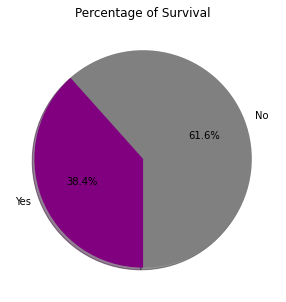

Column Headers:
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Top 10 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, M

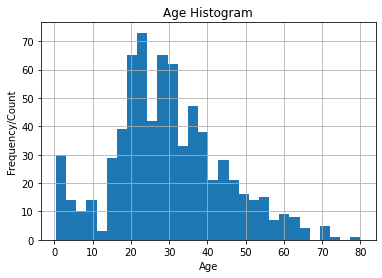

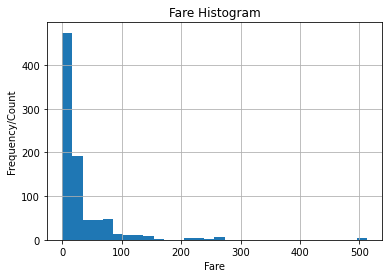


*****FUNCTION data_cleaning*****
Shape Before Dropping rows and columns: (891, 12)
   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S
5         0       3    male   NaN      0      0   8.4583        Q
6         0       1    male  54.0      0      0  51.8625        S
7         0       3    male   2.0      3      1  21.0750        S
8         1       3  female  27.0      0      2  11.1333        S
9         1       2  female  14.0      1      0  30.0708        C
Null Percent after dropping rows:
Survived    0.000000
Pclass      0.000000
Sex         0.000000
Age         0.199100
SibSp       0.000000
Parch       0.000000
Fare        0.024747
Embarked 

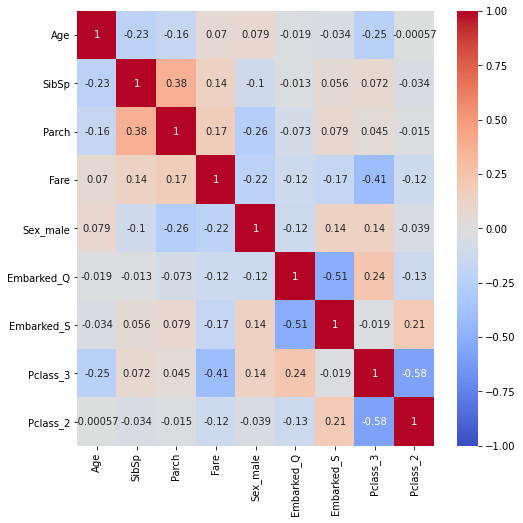

                 Age     SibSp     Parch      Fare  Sex_male  Embarked_Q  \
Age         1.000000  0.233563  0.159520  0.069531  0.078504    0.018972   
SibSp       0.233563  1.000000  0.377414  0.144346  0.102967    0.012662   
Parch       0.159520  0.377414  1.000000  0.172167  0.262075    0.073142   
Fare        0.069531  0.144346  0.172167  1.000000  0.224406    0.116757   
Sex_male    0.078504  0.102967  0.262075  0.224406  1.000000    0.124749   
Embarked_Q  0.018972  0.012662  0.073142  0.116757  0.124749    1.000000   
Embarked_S  0.033967  0.056358  0.078900  0.166400  0.139922    0.512287   
Pclass_3    0.246174  0.072295  0.044903  0.409554  0.138775    0.238911   
Pclass_2    0.000572  0.034062  0.015397  0.115079  0.038518    0.126061   

            Embarked_S  Pclass_3  Pclass_2  
Age           0.033967  0.246174  0.000572  
SibSp         0.056358  0.072295  0.034062  
Parch         0.078900  0.044903  0.015397  
Fare          0.166400  0.409554  0.115079  
Sex_male      

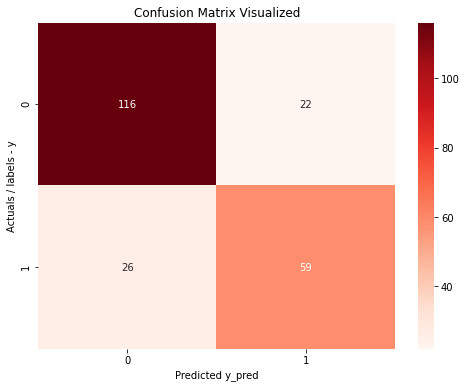

Accuracy: 0.7847533632286996
Precision: 0.7283950617283951
Specificity: 0.8405797101449275
Recall: 0.6941176470588235
False Positive Rate: 0.15942028985507245
**************************** Model Ready to be used/invoked ***************************


127.0.0.1 - - [05/Aug/2021 12:44:55] "POST /build_mod HTTP/1.1" 200 -
127.0.0.1 - - [05/Aug/2021 12:45:04] "POST /use HTTP/1.1" 200 -
127.0.0.1 - - [05/Aug/2021 12:45:10] "POST /make_pred HTTP/1.1" 200 -


Type of the file is : <class 'werkzeug.datastructures.FileStorage'>
titanic_new_data1.csv
Input File extension good titanic_new_data1.csv

*****FUNCTION read_data*****
   PassengerId  Pclass  Name     Sex  Age  SibSp  Parch  Ticket  Fare Cabin  \
0          123       3   Ray    male   66      0      0  456789    35   G13   
1          843       1   Bob    male   15      2      2  D43190   421   C45   
2          987       1  Mary  female   22      1      1  123456   500   A13   
3          456       1   Ann  feamle   41      2      2  C12121   300   B21   
4          214       2  john    male   35      4      2   D4563   125   F14   

  Embarked  
0        Q  
1        Q  
2        Q  
3        S  
4        S  
Shape of Full set:
(6, 11)

*****FUNCTION data_cleaning*****
Shape Before Dropping rows and columns: (6, 11)
   Pclass     Sex  Age  SibSp  Parch  Fare Embarked
0       3    male   66      0      0    35        Q
1       1    male   15      2      2   421        Q
2       1  fem

127.0.0.1 - - [05/Aug/2021 12:45:16] "POST /make_pred HTTP/1.1" 200 -


Type of the file is : <class 'werkzeug.datastructures.FileStorage'>
titanic_new_data2.csv
Input File extension good titanic_new_data2.csv

*****FUNCTION read_data*****
   PassengerId  Pclass    Name     Sex  Age  SibSp  Parch  Ticket  Fare Cabin  \
0           96       1  Thomas    male   20      1      1    9781   400   B32   
1          543       3    Lori  female   15      2      2  H74456    24   G31   
2          136       2  Justin    male   54      1      1    G536   200   F13   
3          279       1    Paul    male   61      2      2   A9897   300   C21   
4          851       2    Kate  female   35      4      2  565757   175   D14   

  Embarked  
0        Q  
1        Q  
2        Q  
3        S  
4        S  
Shape of Full set:
(6, 11)

*****FUNCTION data_cleaning*****
Shape Before Dropping rows and columns: (6, 11)
   Pclass     Sex  Age  SibSp  Parch  Fare Embarked
0       1    male   20      1      1   400        Q
1       3  female   15      2      2    24        Q
2 

In [20]:
# Main Program for Web app
# If __name__ = __main__ ,program is running standalone
if __name__ == "__main__":
    print("Python script is run standalone")
    print("Python special variable __name__ =", __name__)   
        
       
    # Run the flask app in jupyter noetbook needs run_simple 
    # Run the flask app in python script needs app.run
    # run_simple('localhost',8084, app, use_debugger=True)
    application.run('0.0.0.0')

     
else:
    # __name__ will have the name of the module that imported this script
    print("Python script was imported")
    print("Python special variable __name__ =", __name__)   
#End Main program